In [4]:
# Import librarys
from run_ac import *
import os
from tqdm import tqdm
import time
from func import *
import geopandas as gpd
from matplotlib import pyplot as plt
from scipy import stats

In [5]:
# Read in forcing data
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])

# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

In [6]:
# Replace the timestamp from LAI
new_time_range = pd.date_range(start='2000-01-01', end='2023-12-31', freq='D')
lai_data['time'] = new_time_range

# Replace first 48 days with them from 2001
torep = lai_data.sel(time = slice("2001-01-01","2001-02-17"))
lai_data.values[0:48, :, :] = torep.values

# Fill gaps in LAI
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        if np.isnan(lai_data[:, lat, lon]).all():
            continue
        else:
            # Get the data for the current grid cell
            grid_cell_data = lai_data[:, lat, lon]
            
            # Convert to DataFrame for easier handling
            grid_cell_df = pd.DataFrame(grid_cell_data)
            
            # Fill NA values with the previous value
            grid_cell_df.fillna(method='ffill', inplace=True)
            
            # Update the grid cell data
            lai_data[:, lat, lon] = grid_cell_df.values.flatten()

C:\Users\motze\AppData\Local\Temp\ipykernel_9992\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_9992\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_9992\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_9992\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ff

## Run model with present data

In [7]:
# Prepare data for new model
full_data = np.full((22, 22, 8766, 4), np.nan)
#full_data = np.zeros((22, 22, 8766, 4))

full_data[:, :, :, 0] = P_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 1] = R_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 2] = T_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 3] = lai_data.transpose('latitude', 'longitude', 'time')

In [8]:
# Run model
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]
results = time_evolution(full_data, *params)

current = out2xarray(results)

c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 8495.16it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

In [60]:
def rem_trend(data):
    # Convert temperature data to numpy array
    data_array = data.values

    # Reshape the data into 2D array (time, spatial dimensions)
    time_length = len(data.time)
    spatial_dims = data.shape[1:]
    data_2d = data_array.reshape((time_length, -1))

    # Detrend each grid cell separately
    detrended_data = np.zeros_like(data_2d)
    for i in range(data_2d.shape[1]):
        mean_value = np.mean(data_2d[:,i], axis=0)
        detrended_data[:, i] = detrend(data_2d[:, i], axis=0, type='linear')
        detrended_data[:, i] = detrended_data[:, i] + mean_value

    # Reshape detrended data back to its original shape
    output = xr.DataArray(detrended_data.reshape((time_length,) + spatial_dims),
                          coords=data.coords, dims=data.dims)

    return output

## Detrend data

In [61]:
T_data_detrend = rem_trend(T_data)
R_data_detrend = rem_trend(R_data)

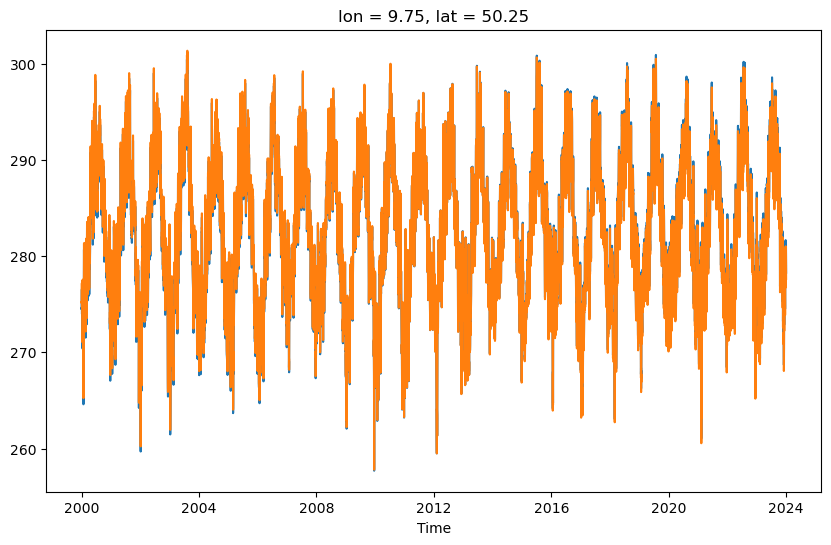

In [62]:
plt.figure(figsize=(10, 6))
T_data.isel(lat=10, lon=10).plot(x='time')
T_data_detrend.isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

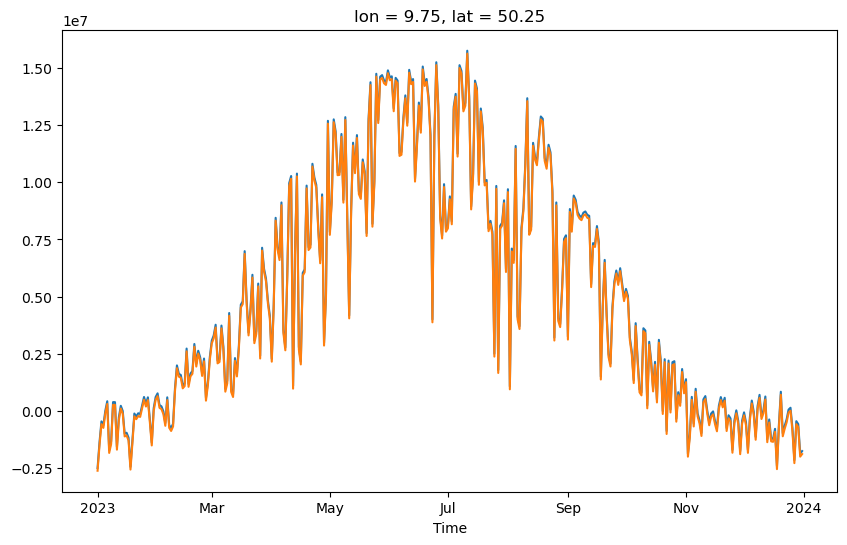

In [63]:
plt.figure(figsize=(10, 6))
R_data.sel(time='2023').isel(lat=10, lon=10).plot(x='time')
R_data_detrend.sel(time='2023').isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

## Prepare model for detrended data

In [64]:
# Prepare detrendeddata for new model
full_data_detrend = np.full((22, 22, 8766, 4), np.nan)
#full_data = np.zeros((22, 22, 8766, 4))

full_data_detrend[:, :, :, 0] = P_data.transpose('lat', 'lon', 'time')
full_data_detrend[:, :, :, 1] = R_data_detrend.transpose('lat', 'lon', 'time')
full_data_detrend[:, :, :, 2] = T_data_detrend.transpose('lat', 'lon', 'time')
full_data_detrend[:, :, :, 3] = lai_data.transpose('latitude', 'longitude', 'time')

In [65]:
# Run model
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]
results_detrend = time_evolution(full_data_detrend, *params)

current_detrend = out2xarray(results_detrend)

c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 6956.77it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

In [66]:
diffrence = current - current_detrend

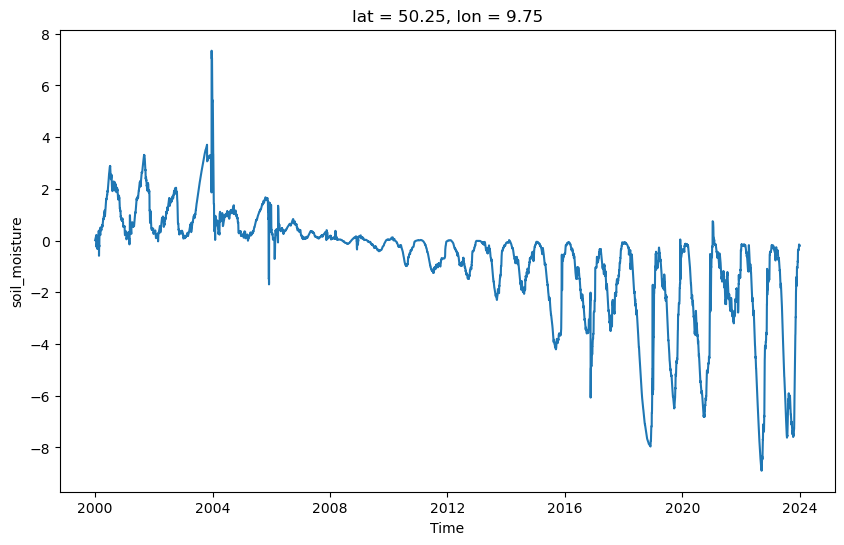

In [67]:
plt.figure(figsize=(10, 6))
(diffrence['soil_moisture']).isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

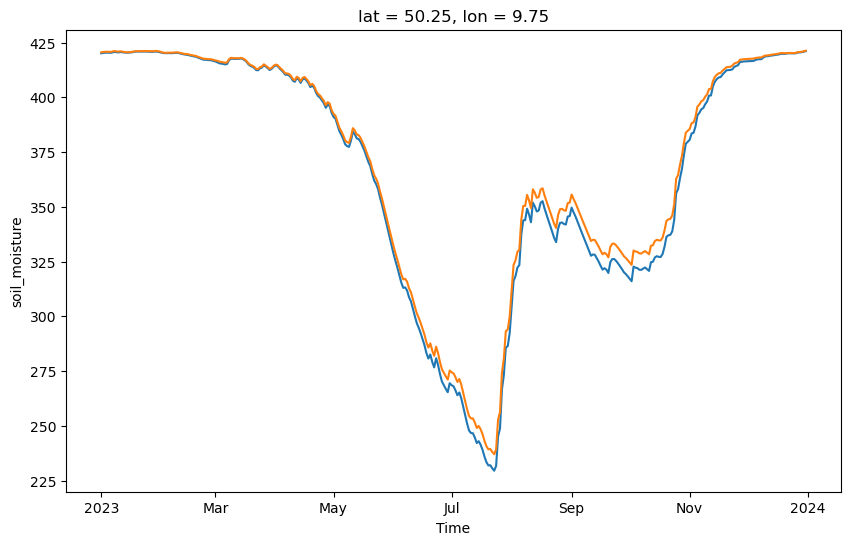

In [68]:
plt.figure(figsize=(10, 6))
current['soil_moisture'].sel(time='2023').isel(lat=10, lon=10).plot(x='time')
current_detrend['soil_moisture'].sel(time='2023').isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

In [69]:
current_mean = current.mean(dim='time')

C:\Users\motze\AppData\Local\Temp\ipykernel_9992\4209045016.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


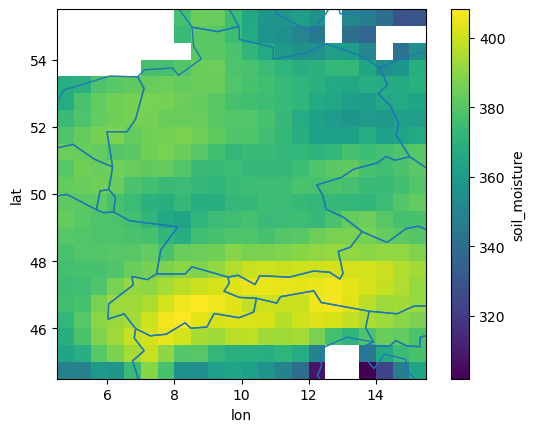

In [70]:

# Load country boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the mean soil moisture
current_mean['soil_moisture'].plot()

# Plot country boundaries
world.boundary.plot(ax=plt.gca(), linewidth=1)

plt.show()

In [71]:
dif_per = diffrence / current_mean

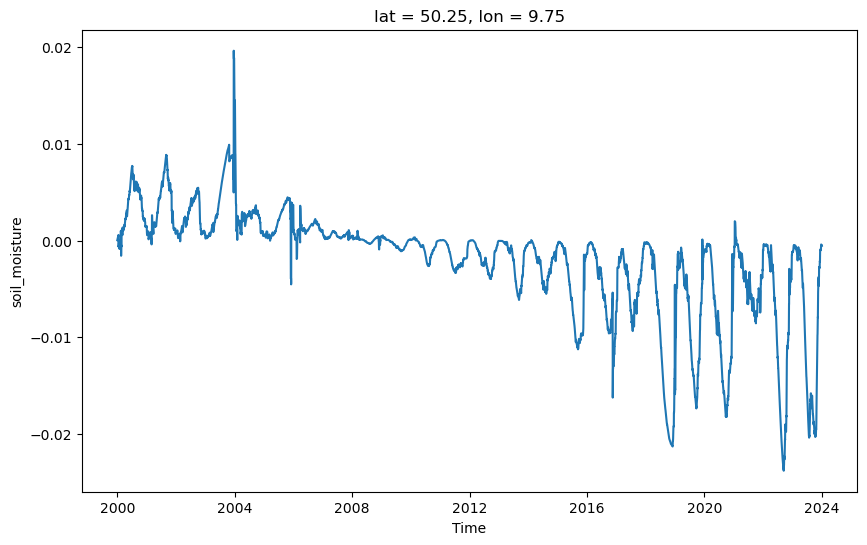

In [72]:
plt.figure(figsize=(10, 6))
dif_per['soil_moisture'].isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

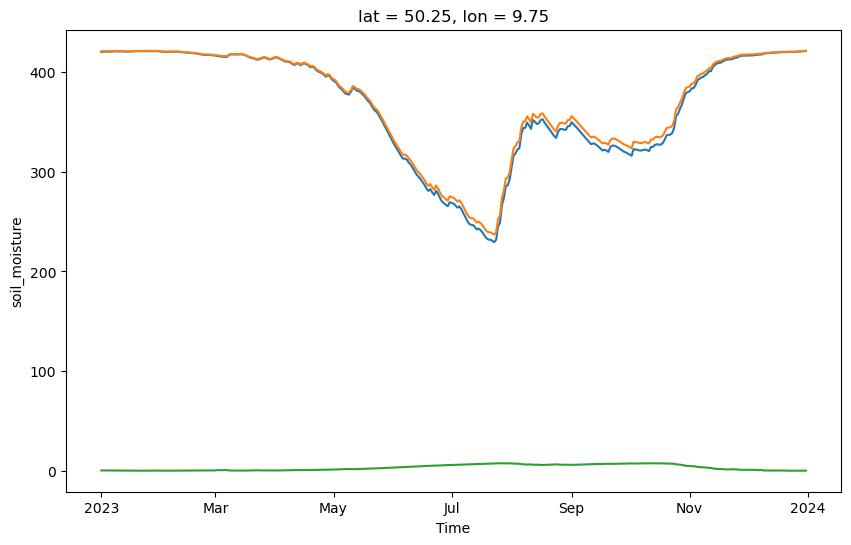

In [73]:
plt.figure(figsize=(10, 6))
current['soil_moisture'].sel(time='2023').isel(lat=10, lon=10).plot(x='time')
current_detrend['soil_moisture'].sel(time='2023').isel(lat=10, lon=10).plot(x='time')
abs(diffrence['soil_moisture']).sel(time='2023').isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

C:\Users\motze\AppData\Local\Temp\ipykernel_9992\3458899805.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


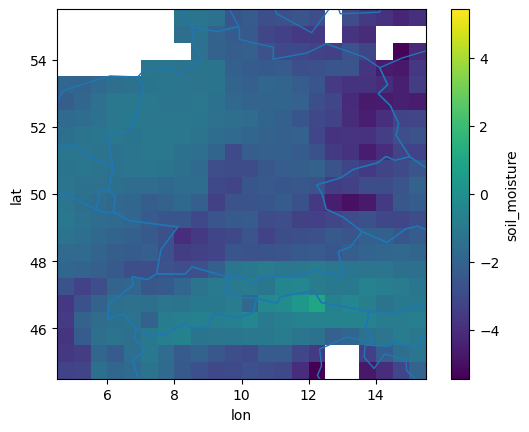

In [77]:
# Load country boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the mean soil moisture
diffrence['soil_moisture'].sel(time='2023').mean(dim='time').plot(cmap ='viridis')


# Plot country boundaries
world.boundary.plot(ax=plt.gca(), linewidth=1)

plt.show()

C:\Users\motze\AppData\Local\Temp\ipykernel_9992\942929512.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


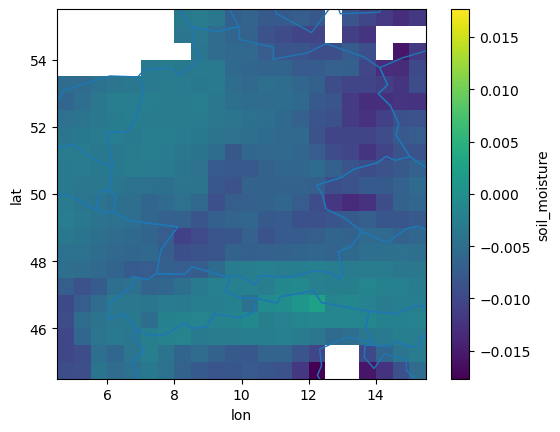

In [78]:
# Load country boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the mean soil moisture
dif_per['soil_moisture'].sel(time='2023').mean(dim='time').plot(cmap ='viridis')


# Plot country boundaries
world.boundary.plot(ax=plt.gca(), linewidth=1)

plt.show()

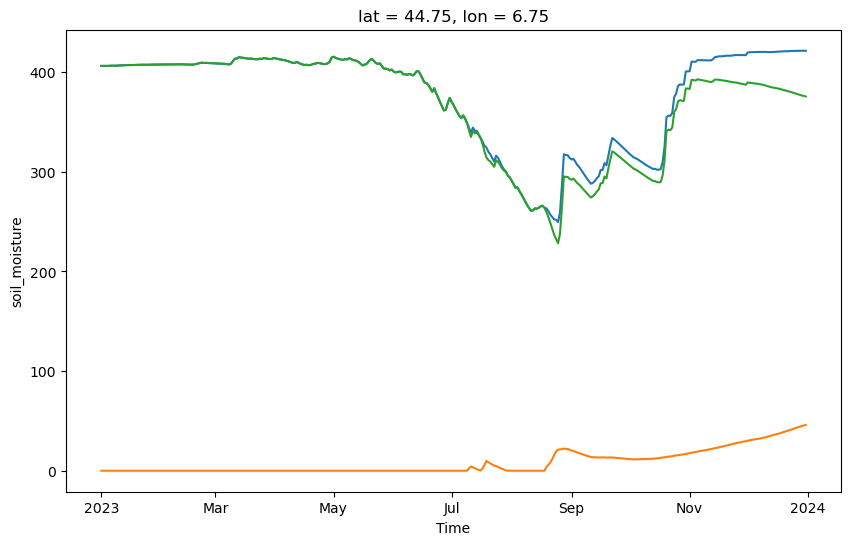

In [55]:
plt.figure(figsize=(10, 6))
current['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time')
current_detrend['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time')
diffrence['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

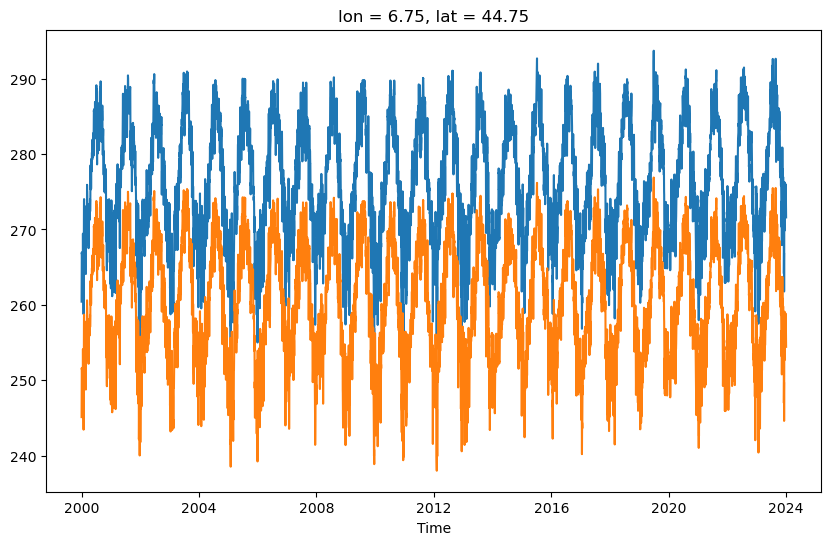

In [56]:
plt.figure(figsize=(10, 6))
T_data.isel(lat=21, lon=4).plot(x='time')
T_data_detrend.isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

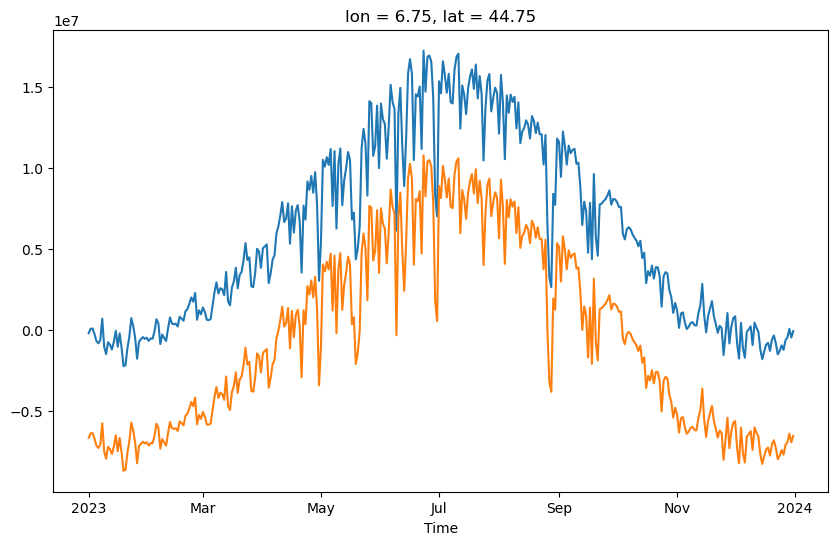

In [57]:
plt.figure(figsize=(10, 6))
R_data.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
R_data_detrend.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

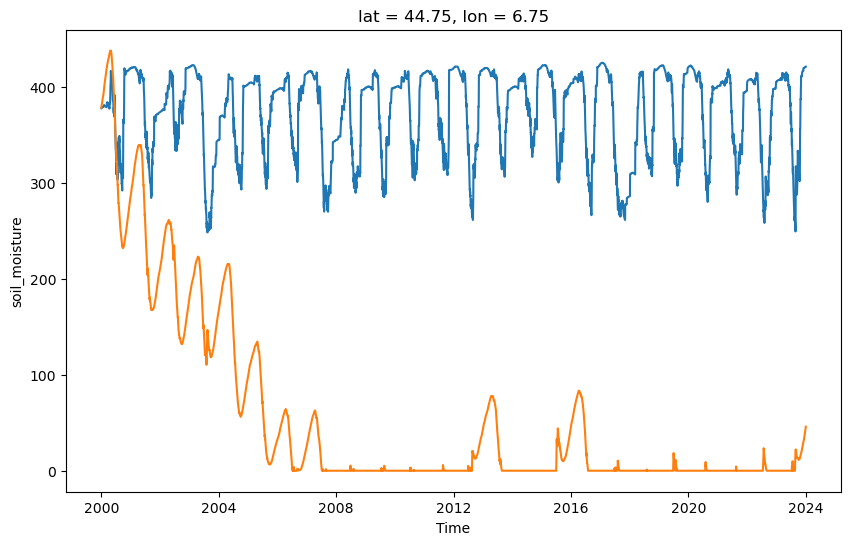

In [58]:
plt.figure(figsize=(10, 6))
current['soil_moisture'].isel(lat=21, lon=4).plot(x='time')
current_detrend['soil_moisture'].isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

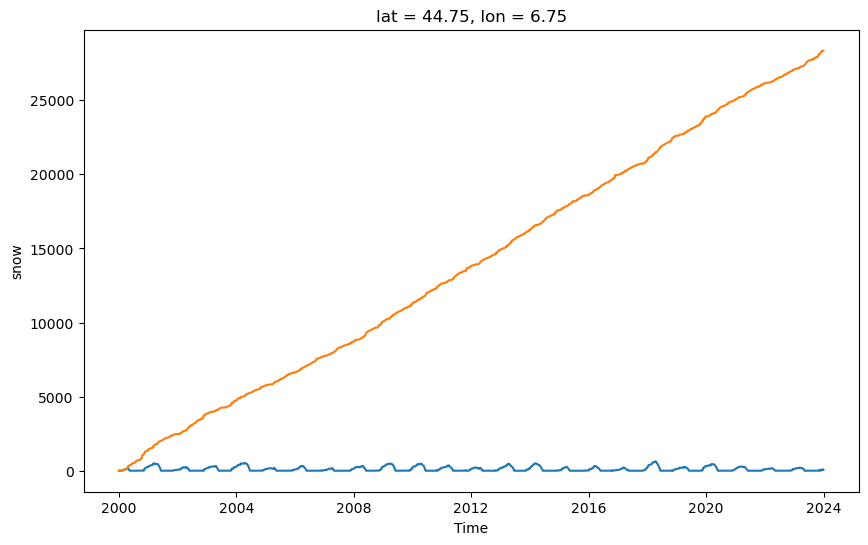

In [59]:
plt.figure(figsize=(10, 6))
current['snow'].isel(lat=21, lon=4).plot(x='time')
current_detrend['snow'].isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

## Multiply trend

In [118]:
T_multiplied = np.full_like(T_data, np.nan)

test = T_data[:,21,4].values
time = np.arange(len(T_data))
slope, intercept, _, _, _ = stats.linregress(time, test)
slope_multiplier = 2
new_values = time * slope * slope_multiplier
T_multiplied = T_data[:,21,4] + new_values

In [119]:
slope

0.00021167682608841623

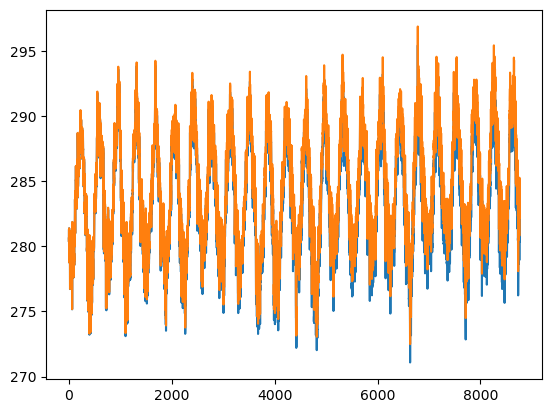

In [112]:
plt.plot(test)
plt.plot(T_multiplied)

In [113]:
def calc_temp(data, multiplier=2):
    time = np.arange(len(data))
    slope, intercept, _, _, _ = stats.linregress(time, data)
    new_values = time * slope * multiplier
    return data + new_values

# Apply the function to each grid cell
T_multiplied = xr.apply_ufunc(
    calc_temp,
    T_data,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
    kwargs={'multiplier': 2}
)


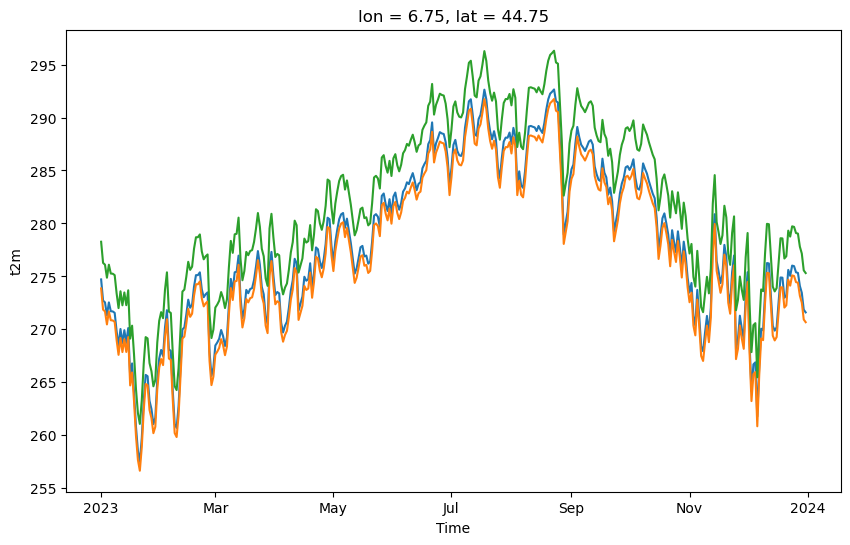

In [114]:
plt.figure(figsize=(10, 6))
T_data.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
T_data_detrend.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
T_multiplied.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

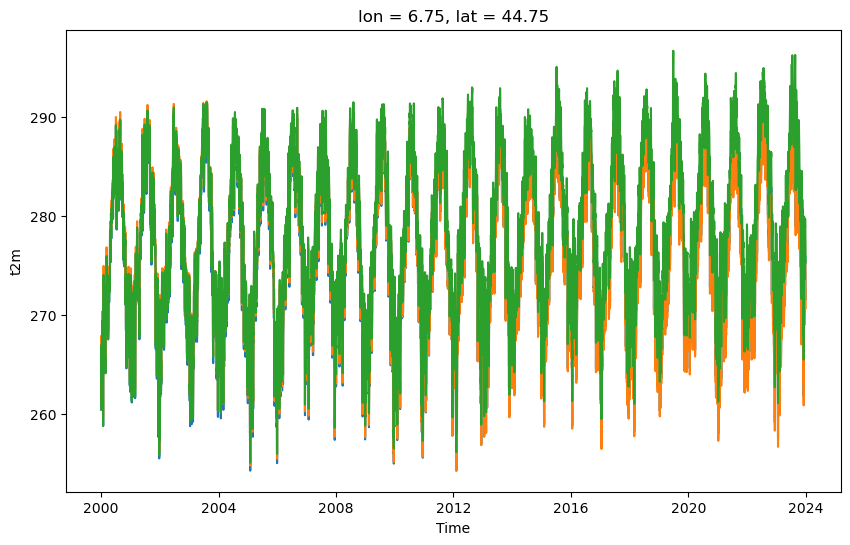

In [116]:
plt.figure(figsize=(10, 6))
T_data.isel(lat=21, lon=4).plot(x='time')
T_data_detrend.isel(lat=21, lon=4).plot(x='time')
T_multiplied.isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

In [122]:
def calc_temp(data, multiplier=2):
    time = np.arange(len(data))
    slope, intercept, _, _, _ = stats.linregress(time, data)
    new_values = time * slope * multiplier
    return data + new_values, slope

# Apply the function to each grid cell
T_multiplied, mean_slopes = xr.apply_ufunc(
    calc_temp,
    T_data,
    input_core_dims=[['time']],
    output_core_dims=[['time'], []],  # Return an extra dimension for the slopes
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float],
    kwargs={'multiplier': 2}
)

In [125]:
mean_slopes

<xarray.DataArray 't2m' (lat: 22, lon: 22)> Size: 4kB
array([[0.00010635, 0.00010952, 0.0001121 , 0.00011339, 0.00011188,
        0.00011127, 0.00011721, 0.00011972, 0.00011805, 0.00012232,
        0.00012646, 0.00012848, 0.00013129, 0.000136  , 0.00014372,
        0.0001531 , 0.00015999, 0.00016237, 0.00016128, 0.00015935,
        0.00016025, 0.00016292],
       [0.00011304, 0.00011419, 0.00011542, 0.00011724, 0.00011866,
        0.00012005, 0.00012066, 0.0001184 , 0.00011998, 0.00012736,
        0.00013096, 0.00012796, 0.00012392, 0.00012781, 0.00013922,
        0.00014743, 0.00015344, 0.00016035, 0.00016324, 0.0001627 ,
        0.00016217, 0.00016271],
       [0.00011295, 0.00011268, 0.00011342, 0.00011502, 0.00011788,
        0.00011992, 0.00011707, 0.00011387, 0.00012087, 0.00013098,
        0.00013384, 0.00013262, 0.00013001, 0.00013187, 0.00013812,
        0.00014022, 0.00014288, 0.00014847, 0.00015605, 0.00016446,
        0.00016273, 0.00015564],
       [0.00011128, 0.00010728, 0.00010608, 0.00010721, 0.00011137,
        0.00011582, 0.00011697, 0.00011806, 0.00012568, 0.00013595,
        0.00014322, 0.00014666, 0.00014597, 0.00014529, 0.00014516,
        0.00014381, 0.00014224, 0.0001417 , 0.00014693, 0.00015546,
        0.00015381, 0.00014683],
...
       [0.00016185, 0.00015857, 0.00016645, 0.00018924, 0.00020522,
        0.00022085, 0.00023446, 0.00022236, 0.00020723, 0.00021348,
        0.00023394, 0.00024053, 0.00023577, 0.00023673, 0.0002117 ,
        0.00018141, 0.00018029, 0.00017791, 0.00016877, 0.00016442,
        0.00016335, 0.00015686],
       [0.00016878, 0.00016759, 0.00018573, 0.00021354, 0.00021495,
        0.00021674, 0.00021659, 0.00019514, 0.00018669, 0.00019147,
        0.00020328, 0.00020861, 0.00020336, 0.00019261, 0.00016346,
        0.00014122, 0.00014766, 0.00015663, 0.00016386, 0.00017149,
        0.00017334, 0.00016458],
       [0.00016629, 0.0001724 , 0.00019909, 0.00021665, 0.00021443,
        0.00021145, 0.00020279, 0.00018359, 0.00015982, 0.00014768,
        0.00014457, 0.00014124, 0.00014396, 0.00014374, 0.00013258,
        0.00012999, 0.00013978, 0.00014577, 0.00014805, 0.00016049,
        0.00017403, 0.00016846],
       [0.00016453, 0.00017398, 0.00019918, 0.00021472, 0.00021168,
        0.00020369, 0.00019565, 0.00018777, 0.00017415, 0.00016395,
        0.00015285, 0.00014037, 0.00013811, 0.0001397 , 0.00013805,
        0.00014055, 0.00014724, 0.00014525, 0.00013955, 0.00014739,
        0.00016317, 0.00017125]])
Coordinates:
  * lon      (lon) float64 176B 4.75 5.25 5.75 6.25 ... 13.75 14.25 14.75 15.25
  * lat      (lat) float64 176B 55.25 54.75 54.25 53.75 ... 45.75 45.25 44.75

C:\Users\motze\AppData\Local\Temp\ipykernel_9992\2851035803.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


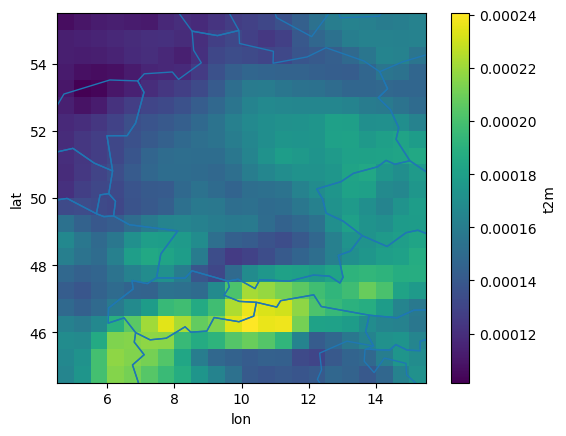

In [127]:
# Load country boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the mean soil moisture
mean_slopes.plot(cmap ='viridis')


# Plot country boundaries
world.boundary.plot(ax=plt.gca(), linewidth=1)

plt.show()

In [130]:
def detrend_temp(data):
    time = np.arange(len(data))
    slope, intercept, _, _, _ = stats.linregress(time, data)
    detrended_values = data - (time * slope)
    return detrended_values

# Apply the function to each grid cell
T_detrended = xr.apply_ufunc(
    detrend_temp,
    T_data,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [131]:
R_detrended = xr.apply_ufunc(
    detrend_temp,
    R_data,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [132]:
# Prepare detrendeddata for new model
full_data_detrended = np.full((22, 22, 8766, 4), np.nan)
#full_data = np.zeros((22, 22, 8766, 4))

full_data_detrended[:, :, :, 0] = P_data.transpose('lat', 'lon', 'time')
full_data_detrended[:, :, :, 1] = R_detrended.transpose('lat', 'lon', 'time')
full_data_detrended[:, :, :, 2] = T_detrended.transpose('lat', 'lon', 'time')
full_data_detrended[:, :, :, 3] = lai_data.transpose('latitude', 'longitude', 'time')

In [133]:
# Run model
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]
results_detrended = time_evolution(full_data_detrended, *params)

new_detrend = out2xarray(results_detrended)

c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 8105.84it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

In [134]:
newdiffrence = current - new_detrend

In [136]:
def plot_comp(data, data_future, source):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    min_val = min(data[source].mean(dim='time').quantile(0.05).values,
              data_future[source].mean(dim='time').quantile(0.05).values)
    max_val = max(data[source].mean(dim='time').quantile(0.95).values,
                data_future[source].mean(dim='time').quantile(0.95).values)
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the data for the present in the second subplot
    im2 = data[source].mean(dim='time').plot(ax=axs[0], cmap='viridis', vmin=min_val, vmax=max_val)
    axs[0].set_title('Present 2000-2024')

    # Plot the mean soil moisture for the future in the first subplot
    im1 = data_future[source].mean(dim='time').plot(ax=axs[1], cmap='viridis',vmin=min_val, vmax=max_val)
    axs[1].set_title('Future 2076-2100')

    # Plot country boundaries
    world.boundary.plot(ax=axs[0], linewidth=1)
    world.boundary.plot(ax=axs[1], linewidth=1)

    plt.show()

C:\Users\motze\AppData\Local\Temp\ipykernel_9992\2579918408.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


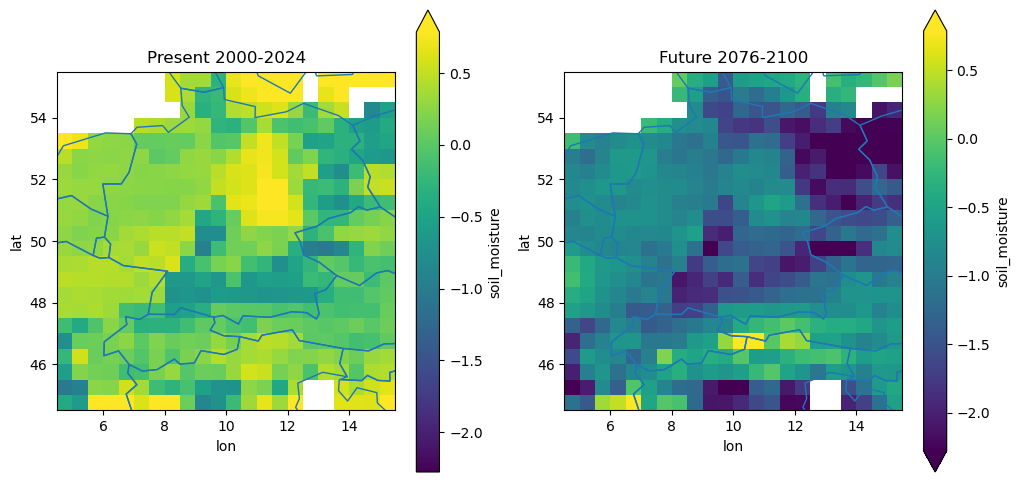

In [138]:
plot_comp(diffrence, newdiffrence, 'soil_moisture')

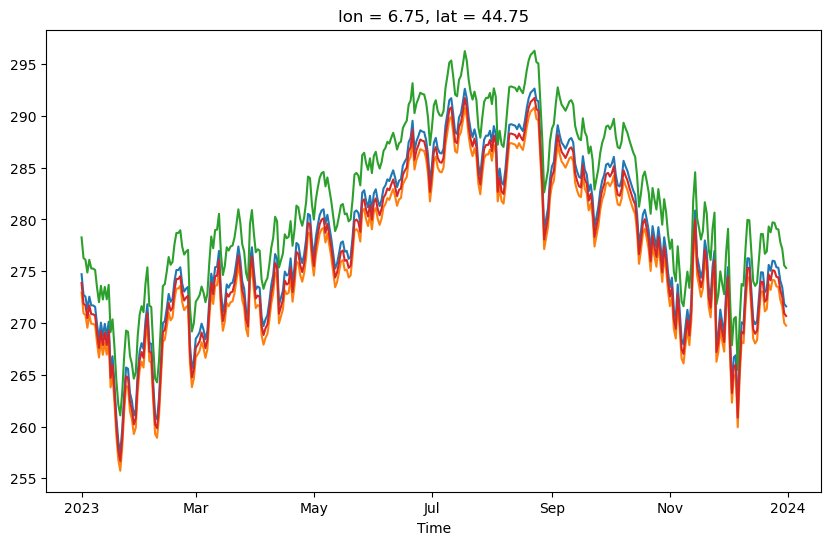

In [140]:
plt.figure(figsize=(10, 6))
T_data.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
T_detrended.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
T_multiplied.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
T_data_detrend.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()